In [ ]:
! pip install kaggle
! mkdir ~/.kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ikarus777/best-artworks-of-all-time

100% 2.28G/2.29G [00:14<00:00, 168MB/s]
100% 2.29G/2.29G [00:14<00:00, 165MB/s]


In [ ]:
! unzip best-artworks-of-all-time.zip

Streaming output truncated to the last 5000 lines.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflat

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-nhg1zimk
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-nhg1zimk
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=182abbad6737d833045256efb614faa9e59043508729f3a0b7c95f91d782a25e
  Stored in directory: /tmp/pip-ephem-wheel-cache-rz5lkppb/wheels/67/d2/f4/96ae3c3c62d1e05abfc8860ad0c1207794726d44ebbbb547f3
Successfully built keras-contrib


In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
import scipy

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers import LeakyReLU, ELU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.layers import add
from keras.models import Sequential, Model
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras import backend as K
from keras import layers
from keras.layers import Layer, InputSpec
import tensorflow as tf


from keras.utils import plot_model

import datetime
import matplotlib.pyplot as plt
import sys

import numpy as np
import os
import pickle as pkl
import random


In [ ]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')


In [ ]:
IMAGE_SIZE = 128
img_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
learning_rate = 0.0002
buffer_max_length = 50
lambda_validation = 1
lambda_reconstr = 10
lambda_id = 2
gen_n_filters = 32
disc_n_filters = 32
weight_init = RandomNormal(mean=0., stddev=0.02)
patch = int(img_shape[0] / 2**3)
disc_patch = (patch, patch, 1)
batch_size = 1

In [ ]:
def build_generator_resnet():

  def conv7s1(layer_input, filters, final):
    y = ReflectionPadding2D(padding =(3,3))(layer_input)
    y = Conv2D(filters, kernel_size=(7,7), strides=1, padding='valid', kernel_initializer = weight_init)(y)
    if final:
      y = Activation('tanh')(y)
    else:
      y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
      y = Activation('relu')(y)
    return y

  def downsample(layer_input,filters):
    y = Conv2D(filters, kernel_size=(3,3), strides=2, padding='same', kernel_initializer = weight_init)(layer_input)
    y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
    y = Activation('relu')(y)
    return y

  def residual(layer_input, filters):
    shortcut = layer_input
    y = ReflectionPadding2D(padding =(1,1))(layer_input)
    y = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='valid', kernel_initializer = weight_init)(y)
    y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
    y = Activation('relu')(y)
            
    y = ReflectionPadding2D(padding =(1,1))(y)
    y = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='valid', kernel_initializer = weight_init)(y)
    y = InstanceNormalization(axis = -1, center = False, scale = False)(y)

    return add([shortcut, y])

  def upsample(layer_input,filters):
    y = Conv2DTranspose(filters, kernel_size=(3, 3), strides=2, padding='same', kernel_initializer = weight_init)(layer_input)
    y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
    y = Activation('relu')(y)
    
    return y


  # Image input
  img = Input(shape=img_shape)

  y = img

  y = conv7s1(y, gen_n_filters, False)
  y = downsample(y, gen_n_filters * 2)
  y = downsample(y, gen_n_filters * 4)
  y = residual(y, gen_n_filters * 4)
  y = residual(y, gen_n_filters * 4)
  y = residual(y, gen_n_filters * 4)
  y = residual(y, gen_n_filters * 4)
  y = residual(y, gen_n_filters * 4)
  y = residual(y, gen_n_filters * 4)
  y = residual(y, gen_n_filters * 4)
  y = residual(y, gen_n_filters * 4)
  y = residual(y, gen_n_filters * 4)
  y = upsample(y, gen_n_filters * 2)
  y = upsample(y, gen_n_filters)
  y = conv7s1(y, 3, True)
  output = y

  gen_model = Model(img, output)
  gen_model.summary()
  return gen_model

In [ ]:
def build_discriminator():

  def conv4(layer_input,filters, stride = 2, norm=True):
    y = Conv2D(filters, kernel_size=(4,4), strides=stride, padding='same', kernel_initializer = weight_init)(layer_input)
            
    if norm:
      y = InstanceNormalization(axis = -1, center = False, scale = False)(y)

    y = LeakyReLU(0.2)(y)
           
    return y

  img = Input(shape=img_shape)

  y = conv4(img, disc_n_filters, stride = 2, norm = False)
  y = conv4(y, disc_n_filters*2, stride = 2)
  y = conv4(y, disc_n_filters*4, stride = 2)
  y = conv4(y, disc_n_filters*8, stride = 1)

  output = Conv2D(1, kernel_size=4, strides=1, padding='same',kernel_initializer = weight_init)(y)
  model = Model(img,output)
  model.summary()
  return model

In [ ]:
g_AB = build_generator_resnet()
g_BA = build_generator_resnet()
d_A = build_discriminator()
d_B = build_discriminator()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 reflection_padding2d (Reflecti  (None, 134, 134, 3)  0          ['input_1[0][0]']                
 onPadding2D)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  4736        ['reflection_padding2d[0][0]']   
                                )                                                             

In [ ]:
# Build and compile the discriminators
d_A.compile(loss='mse',
            optimizer=Adam(learning_rate, 0.5),
            metrics=['accuracy'])
d_B.compile(loss='mse',
            optimizer=Adam(learning_rate, 0.5),
            metrics=['accuracy'])

# For the combined model we will only train the generators
d_A.trainable = False
d_B.trainable = False

# Input images from both domains
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# Translate images to the other domain
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)
# Translate images back to original domain
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)
# Identity mapping of images
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# Discriminators determines validity of translated images
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

# Combined model trains generators to fool discriminators
combined = Model(inputs=[img_A, img_B],
                  outputs=[ valid_A, valid_B,
                          reconstr_A, reconstr_B,
                            img_A_id, img_B_id ])
combined.compile(loss=['mse', 'mse',
                        'mae', 'mae',
                      'mae', 'mae'],
                loss_weights=[ lambda_validation,lambda_validation,
                               lambda_reconstr, lambda_reconstr,
                              lambda_id, lambda_id ],
                            optimizer=Adam(0.0002, 0.5))
d_A.trainable = True
d_B.trainable = True

In [ ]:
def train_discriminators(imgs_A, imgs_B, batch_size = 1):
  
  valid = np.ones((batch_size,) + disc_patch)
  fake = np.zeros((batch_size,) + disc_patch)
# Translate images to opposite domain
  fake_B = g_AB.predict(imgs_A)
  fake_A = g_BA.predict(imgs_B)

# Train the discriminators (original images = real / translated = Fake)
  dA_loss_real = d_A.fit(imgs_A, valid, batch_size = batch_size)
  dA_loss_fake = d_A.fit(fake_A, fake, batch_size = batch_size)
  #dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

  dB_loss_real = d_B.fit(imgs_B, valid, batch_size = batch_size)
  dB_loss_fake = d_B.fit(fake_B, fake, batch_size = batch_size)
  #dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

# Total disciminator loss
  #d_loss_total = 0.5 * np.add(dA_loss, dB_loss)

  return 

In [ ]:
import cv2
import glob

H = 128
W = 128

def process_data(data_path):
  images = [name for name in glob.glob(data_path+'/*.jpg')]
  images = sorted(images)
  return images

def load_data(path):
  x = process_data(path)
  train_x = []
  for i in range(len(x)):
    train_x.append(read_img(x[i]))
  train_x = np.array(train_x)
  return train_x

def read_img(x):
  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  x = cv2.resize(x, (W, H))
  x = x / 255.0
  x = x.astype(np.float32)
  return x

In [ ]:
path = 'images/images/Pablo_Picasso'
path1 = 'images/images/Vincent_van_Gogh'

imgA = load_data(path)
imgB = load_data(path)

print(len(imgA))
print(len(imgB))

439
439


In [ ]:
print(np.expand_dims(imgA[1], axis=0).shape)

(1, 128, 128, 3)


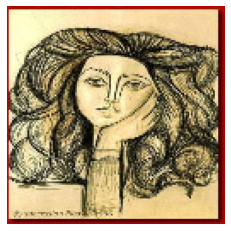

In [ ]:
plt.imshow(imgA[9])
plt.axis("off")
plt.show()

epoch:  0
batch:  0
1/1 [==============================] - 60s 60s/step - loss: 13.7457 - model_2_loss: 0.4328 - model_3_loss: 0.7237 - model_1_loss: 0.4568 - model_loss: 0.5947 - model_1_1_loss: 0.4545 - model_4_loss: 0.5830
batch:  1
1/1 [==============================] - 4s 4s/step - loss: 14.3886 - model_2_loss: 0.7487 - model_3_loss: 0.6491 - model_1_loss: 0.4644 - model_loss: 0.6186 - model_1_1_loss: 0.4619 - model_4_loss: 0.6183
batch:  2
1/1 [==============================] - 5s 5s/step - loss: 14.2005 - model_2_loss: 0.6431 - model_3_loss: 0.5290 - model_1_loss: 0.4683 - model_loss: 0.6177 - model_1_1_loss: 0.4687 - model_4_loss: 0.6156
batch:  3
1/1 [==============================] - 5s 5s/step - loss: 10.2434 - model_2_loss: 0.5612 - model_3_loss: 0.5471 - model_1_loss: 0.3445 - model_loss: 0.4186 - model_1_1_loss: 0.3504 - model_4_loss: 0.4016
batch:  4
1/1 [==============================] - 4s 4s/step - loss: 9.9439 - model_2_loss: 0.5217 - model_3_loss: 0.5977 - model_1_l

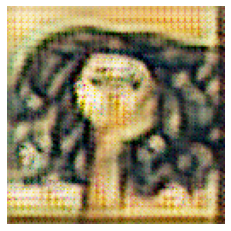

epoch:  1
batch:  0
1/1 [==============================] - 4s 4s/step - loss: 3.7119 - model_2_loss: 0.4240 - model_3_loss: 0.4098 - model_1_loss: 0.1263 - model_loss: 0.1168 - model_1_1_loss: 0.1182 - model_4_loss: 0.1051
batch:  1
1/1 [==============================] - 4s 4s/step - loss: 4.6476 - model_2_loss: 0.3546 - model_3_loss: 0.4110 - model_1_loss: 0.1525 - model_loss: 0.1768 - model_1_1_loss: 0.1385 - model_4_loss: 0.1562
batch:  2
1/1 [==============================] - 4s 4s/step - loss: 6.2961 - model_2_loss: 0.5564 - model_3_loss: 0.5941 - model_1_loss: 0.2135 - model_loss: 0.2172 - model_1_1_loss: 0.2087 - model_4_loss: 0.2106
batch:  3
1/1 [==============================] - 4s 4s/step - loss: 4.6585 - model_2_loss: 0.5184 - model_3_loss: 0.5279 - model_1_loss: 0.1575 - model_loss: 0.1463 - model_1_1_loss: 0.1448 - model_4_loss: 0.1422
batch:  4
1/1 [==============================] - 4s 4s/step - loss: 5.7081 - model_2_loss: 0.5795 - model_3_loss: 0.6035 - model_1_loss: 0

In [ ]:
for epoch in range(200):
  print('epoch: ', epoch)
  valid = np.ones((batch_size,) + disc_patch)
  for i in range(len(imgA)):
    print('batch: ', i)
    img_A = np.expand_dims(imgA[i], axis=0)
    img_B = np.expand_dims(imgB[i], axis=0)
    d_loss = train_discriminators(img_A , img_B)
    combined.fit([img_A, img_B], [valid, valid, img_A, img_B,img_A, img_B])
  img = g_AB.predict(np.expand_dims(imgA[9], axis=0))
  plt.imshow(np.squeeze(img))
  plt.axis("off")
  plt.show()

In [ ]:
img = g_AB.predict(img_A)
plt.imshow(np.squeeze(img))
plt.axis("off")
plt.show()

In [ ]:
plt.imshow(np.squeeze(img_A))
plt.axis("off")
plt.show()

In [ ]:
g_AB.save('/g_AB')
g_BA.save('/g_BA')
d_A.save('/d_A')
d_B.save('/d_B')
combined.save('/combined')